# Data Processing
This example demonstrates selected processing capabilities of PyRaDiSe using the provided [example data](examples.rst). These examples aim to provide insight into the power of PyRaDiSe by demonstrating some available `Filter`.


**Invertibility**


Some `Filter`s presented in this example contain invertible or partially invertible (e.g., removed image content is not restorable, but the associated transformation is reversible) operations, such as transformations, that can be reversed automatically using the appropriate functionality of the process package. This invertibility feature is helpful in situations where the properties of images must be modified for processing and afterward needs to be restored. For example, reversing spatial image properties is required in classic deep learning-based inference scenarios where registering the `IntensityImage` to an atlas is typical before model inference. After model inference, applying the inverse registration transformation is mandatory to obtain `SegmentationImages` aligned with the unmodified original data.

For ease of use, change history logging is automatically achieved by a `TransformTape` instance assigned to each image to guarantee invertibility and reproducibility. Therefore, all `Filter`s must record their application and possible invertible changes on the appropriate `TransformTape` instances. The user is exclusively responsible for applying the `PlaybackTransformTapeFilter` at the correct processing step to execute the inversion process.

The application of the `PlaybackTransformTapeFilter` is shown in the example series 6.


**Extending Filter Set**


Currently, PyRaDiSe incorporates a limited set of `Filter`s that should be sufficient for most auto-segmentation solutions. However, for advanced applications some functionality may need to be implemented by the user. In order to facilitate the evolution of PyRaDiSe we encourage you to share your implementations with the community. The best way to foster PyRaDiSe is by making pull requests on the `PyRaDiSe repository on GitHub <https://github.com/ubern-mia/pyradise>`_.



## Preparation

For executing this example one needs to install `matplotlib` using the following command.

```bash

pip install matplotlib

```

The following code block imports the required dependencies.

In [1]:
from copy import deepcopy

import numpy as np
import SimpleITK as sitk

import pyradise.data as ps_data
import pyradise.fileio as ps_io
import pyradise.process as ps_proc

The subsequent code block defines the necessary paths and implementations of utility functions for this example. For running the example make sure that the paths are adjusted accordingly.

In [2]:
# The path pointing to the directory of a subject
input_subject_dir_path_1 = 'D:/tcia_data/curated_data/VS-SEG-001'

# The path pointing to another subject directory
# (used for some examples only)
input_subject_dir_path_2 = 'D:/tcia_data/curated_data/VS-SEG-002'


# A function to load a subject from disk
def load_subject(input_dir_path: str) -> ps_data.Subject:
    # Crawl for DICOM files
    crawler = ps_io.SubjectDicomCrawler(input_dir_path)
    series_info = crawler.execute()

    # Load the subject
    loader = ps_io.SubjectLoader()
    subject_ = loader.load(series_info)

    return subject_


# A function to render the figures
def show_images(image_left: sitk.Image,
                image_right: sitk.Image,
                slice_index: int = 80,
                color_map: str = 'gray'
                ) -> None:
    import matplotlib.pyplot as plt

    # Get the images as numpy arrays
    image_l_np = sitk.GetArrayFromImage(image_left)
    image_r_np = sitk.GetArrayFromImage(image_right)

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
    ax[0].set_axis_off()
    ax[0].imshow(image_l_np[slice_index, :, :], cmap=color_map)
    ax[1].set_axis_off()
    ax[1].imshow(image_r_np[slice_index, :, :], cmap=color_map)

    # Show the plot
    fig.tight_layout()
    plt.show()
    plt.close(fig)

## Example Series 1: Intensity Module

The following demonstrations show selected functionality from the [intensity module](reference/pyradise.process.intensity.rst) such as:

- Intensity rescaling
- Intensity value clipping
- Laplacian sharpening

Please be aware that changes in intensity values may not always be visible for the human eye or are compensated by the plotting library (i.e., for intensity value rescaling).

### Intensity Rescaling

This example demonstrates a rescaling of the intensity values, including the inversion of the rescaling.

Intensity Value Statistic Before Processing:
min: 0 / max: 1826
Intensity Value Statistic After Processing:
min: 100.0 / max: 500.0
Intensity Value Statistic After TransformTape Playback:
min: 0.0 / max: 1826.0
Intensity Rescaling Result (left: original image, right: processed image)


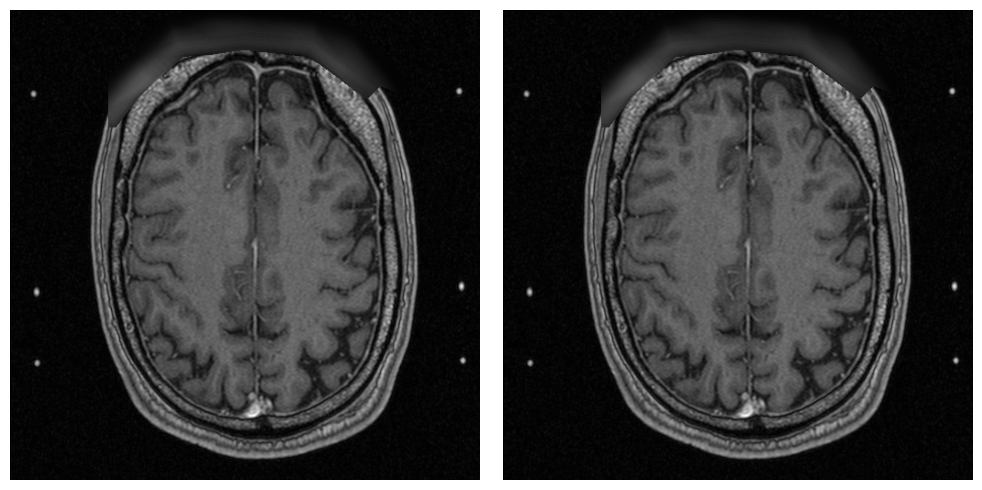

Intensity Rescaling Result (left: processed image, right: back-transformed image)


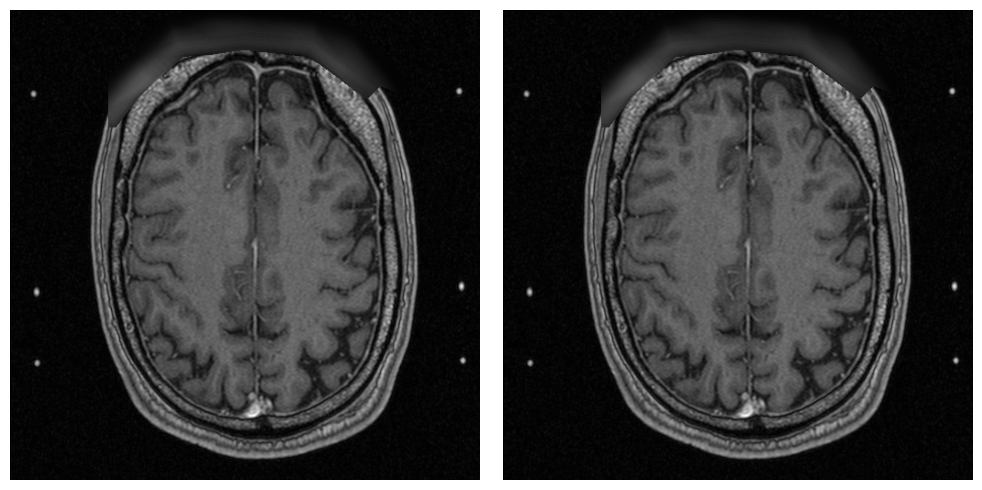

In [ ]:
def rescale_intensity(subject_: ps_data.Subject) -> ps_data.Subject:
    # Rescale the intensity of all images to a minimum and maximum value

    # Set the filter parameters
    min_out = 100
    max_out = 500
    params = ps_proc.RescaleIntensityFilterParams(min_out, max_out)

    # Execute the filter
    return ps_proc.RescaleIntensityFilter().execute(subject_, params)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = rescale_intensity(subject)

# Summarize the results
processed_image = subject.get_image_by_modality('T1').get_image_data(True)

min_in_int = np.min(sitk.GetArrayFromImage(previous_image))
max_in_int = np.max(sitk.GetArrayFromImage(previous_image))
print('Intensity Value Statistic Before Processing:\n'
      f'min: {min_in_int} / max: {max_in_int}')

min_out_int = np.min(sitk.GetArrayFromImage(processed_image))
max_out_int = np.max(sitk.GetArrayFromImage(processed_image))
print('Intensity Value Statistic After Processing:\n'
      f'min: {min_out_int} / max: {max_out_int}')

# Playback the transform type
subject.playback_transform_tapes()

# Further summarize results
back_transformed_image = subject.get_image_by_modality('T1').get_image_data(True)
min_out2_int = np.min(sitk.GetArrayFromImage(back_transformed_image))
max_out2_int = np.max(sitk.GetArrayFromImage(back_transformed_image))
print('Intensity Value Statistic After TransformTape Playback:\n'
      f'min: {min_out2_int} / max: {max_out2_int}')

# Show results (left: original image, right: processed image)
print('Intensity Rescaling Result (left: original image, right: processed image)')
show_images(image_left=previous_image,
            image_right=processed_image)

# Show playback results (left: processed image, right: played back image)
print('Intensity Rescaling Result (left: processed image, right: back-transformed image)')
show_images(image_left=processed_image,
            image_right=back_transformed_image)

### Intensity Clipping

In the following code block the clipping of intensity values with fixed limits is shown.

Intensity Value Statistic Before Processing:
min: 0 / max: 1826
Intensity Value Statistic After Processing:
min: 100 / max: 800


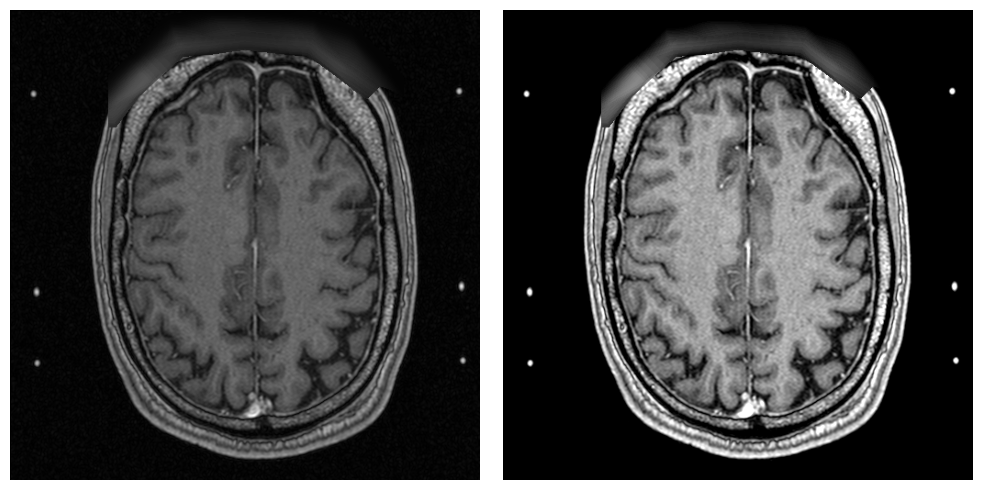

In [ ]:
def clip_intensity(subject_: ps_data.Subject) -> ps_data.Subject:
    # Clip the intensity values of all images to a minimum and maximum value

    # Set the filter parameters
    min_out = 100
    max_out = 800
    params = ps_proc.ClipIntensityFilterParams(min_out, max_out)

    # Execute the filter
    return ps_proc.ClipIntensityFilter().execute(subject_, params)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = clip_intensity(subject)

# Show the result
processed_image = subject.get_image_by_modality('T1').get_image_data(True)

min_in_int = np.min(sitk.GetArrayFromImage(previous_image))
max_in_int = np.max(sitk.GetArrayFromImage(previous_image))
print('Intensity Value Statistic Before Processing:\n'
      f'min: {min_in_int} / max: {max_in_int}')

min_out_int = np.min(sitk.GetArrayFromImage(processed_image))
max_out_int = np.max(sitk.GetArrayFromImage(processed_image))
print('Intensity Value Statistic After Processing:\n'
      f'min: {min_out_int} / max: {max_out_int}')

show_images(image_left=previous_image,
            image_right=processed_image)

### Laplacian Sharpening

This example demonstrates Laplacian sharpening. The `LaplacianFilter` is a straightforward filter that builds on top of SimpleITK's `LaplacianSharpeningImageFilter`. For implementing ITK or SimpleITK-based filters in PyRaDiSe, we recommend looking at this filter's source code.

Laplacian Sharpening Result (left: original T1 image, right: sharpened T1)


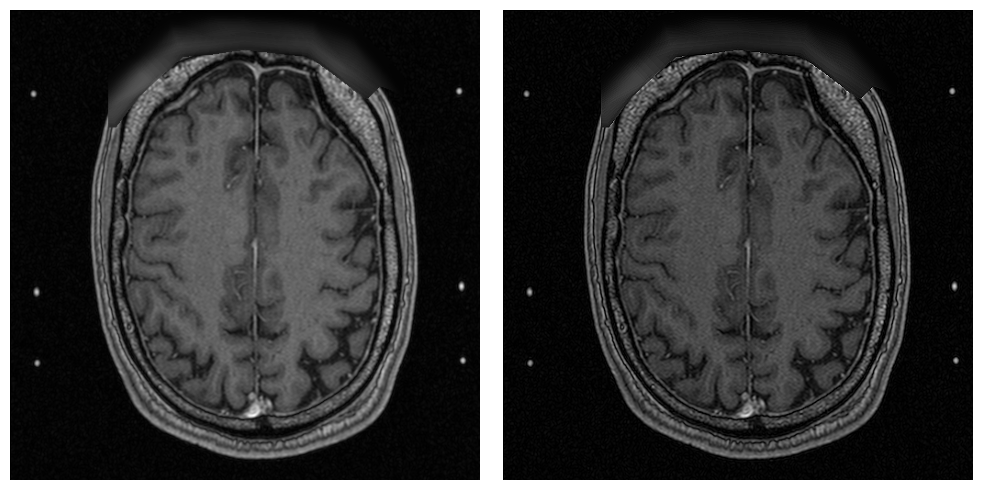

In [ ]:
def laplacian_sharpening(subject_: ps_data.Subject) -> ps_data.Subject:
    # Sharpen with a Laplacian filter the intensity values of all images

    # Set the filter parameters
    params = ps_proc.LaplacianFilterParams()

    # Execute the filter
    return ps_proc.LaplacianFilter().execute(subject_, params)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = laplacian_sharpening(subject)

# Show the result
print('Laplacian Sharpening Result (left: original T1 image, right: sharpened T1)')

processed_image = subject.get_image_by_modality('T1').get_image_data(True)
show_images(image_left=previous_image,
            image_right=processed_image)

## Example Series 2: Orientation Module

In this section functionality of the [orientation module](reference/pyradise.process.orientation.rst) is demonstrated.

### Orientation

Mastering the orientation of medical images can be challenging but is straightforward using the given `OrientationFilter`.

Reorientation Result (left: original T1 image, right: reoriented T1)


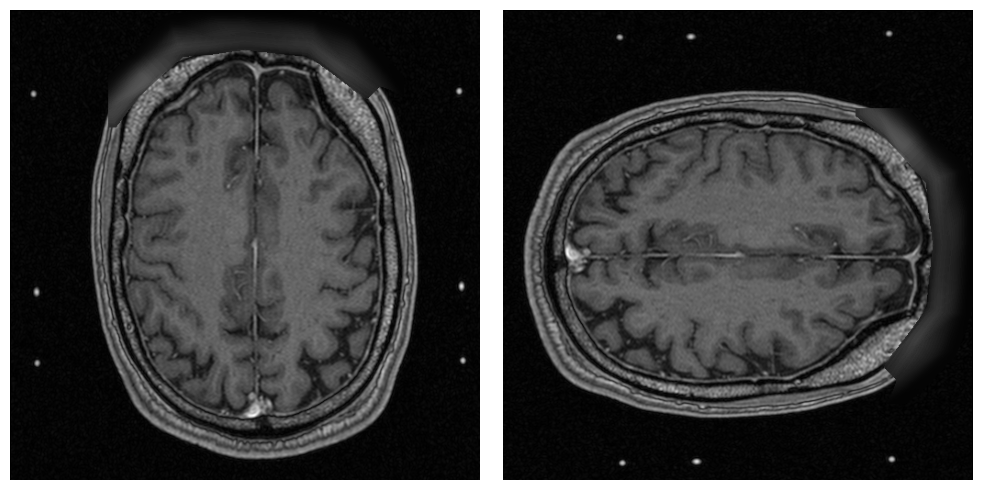

In [ ]:
def reorientation(subject_: ps_data.Subject) -> ps_data.Subject:
    # Reorient the images of a subject

    # Set the filter parameters
    output_orientation = 'ALS'
    params = ps_proc.OrientationFilterParams(output_orientation)

    # Execute the filter
    return ps_proc.OrientationFilter().execute(subject_, params)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = reorientation(subject)

# Show the result
print('Reorientation Result (left: original T1 image, right: reoriented T1)')

processed_image = subject.get_image_by_modality('T1').get_image_data(True)
show_images(image_left=previous_image,
            image_right=processed_image)

## Example Series 3: Registration Module

In the following section some functionality implemented in the [registration module](reference/pyradise.process.registration.rst) is shown, which includes:

- Intra-Subject registration (registration between different images belonging to the same subject)
- Inter-Subject registration (registration between two images of different subjects)

### Intra-Subject Registration

The following example of an intra-subject registration is kept minimally. However, the provided `IntraSubjectRegistrationFilter` tunable with a vast amount of settings to fit for as many tasks as possible.

Intra-Subject Registration Result (left: original T1 image, right: registered T1)
Note: The registration parameters are un-tuned to show the difference.


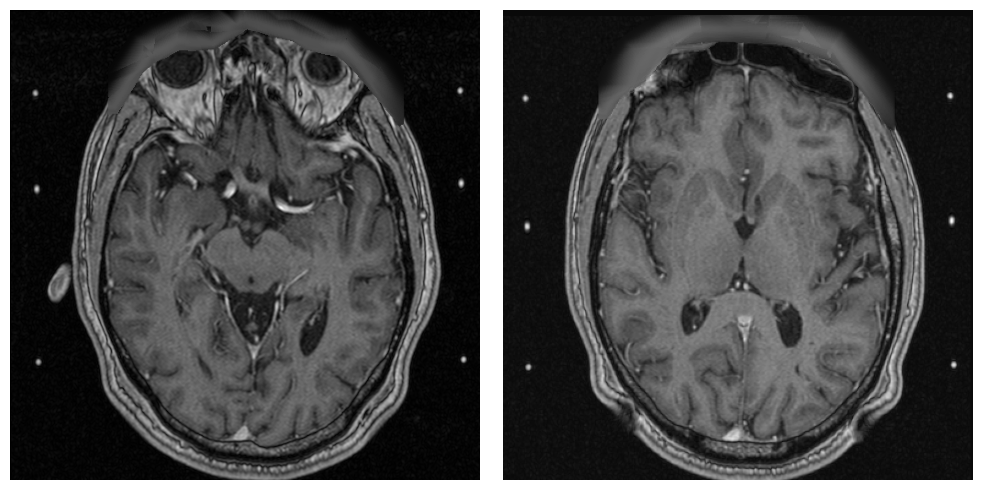

In [ ]:
def intra_subject_registration(subject_: ps_data.Subject) -> ps_data.Subject:
    # Register the T1 and the T1 image of the subject

    # Set the filter parameters
    reference_modality = 'T2'
    params = ps_proc.IntraSubjectRegistrationFilterParams(reference_modality)

    # Execute the filter
    return ps_proc.IntraSubjectRegistrationFilter().execute(subject_, params)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = intra_subject_registration(subject)

# Show the result
print('Intra-Subject Registration Result (left: original T1 image, right: registered T1)')
print('Note: The registration parameters are un-tuned to show the difference.')

processed_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))
show_images(image_left=previous_image,
            image_right=processed_image, slice_index=50)

### Inter-Subject Registration

Similarly to the `IntraSubjectRegistrationFilter`, the `InterSubjectRegistrationFilter` provides a large set of settings that can be tuned to fit most registration tasks.

Inter-Subject Registration Result (left: original T1 image, right: registered T1)
Note: The registration parameters are un-tuned to show the difference.


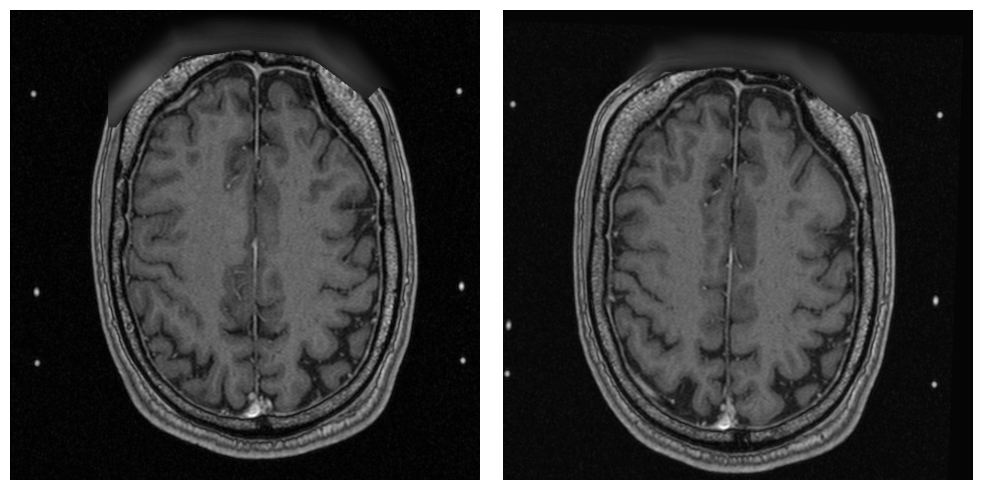

In [ ]:
def inter_subject_registration(subject1: ps_data.Subject,
                               subject2: ps_data.Subject
                               ) -> ps_data.Subject:
    # Register the subject 1 to subject 2 using the T1 as
    # registration pair

    # Set the filter parameters
    ref_mod = 'T1'
    params = ps_proc.InterSubjectRegistrationFilterParams(reference_subject=subject2,
                                                          reference_modality=ref_mod,
                                                          subject_modality=ref_mod)

    # Execute the filter
    return ps_proc.InterSubjectRegistrationFilter().execute(subject1, params)


# Load the subjects from disk
subject_1 = load_subject(input_subject_dir_path_1)
subject_2 = load_subject(input_subject_dir_path_2)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject_1.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = inter_subject_registration(subject_1, subject_2)

# Show the result
print('Inter-Subject Registration Result (left: original T1 image, right: registered T1)')
print('Note: The registration parameters are un-tuned to show the difference.')

processed_image = deepcopy(subject_1.get_image_by_modality('T1').get_image_data(True))
show_images(image_left=previous_image,
            image_right=processed_image)

## Example Series 4: Resampling Module

The following section demonstrates the [resampling module](reference/pyradise.process.resampling.rst) by providing multiple examples of how the `ResampleFilter` can be used.

### Resampling using Transformation

In this example the `ResampleFilter` is used in combination with a SimpleITK transform to translate the content of an image by 20 voxels in two directions.

Resampling Result (left: original image, right: resampled image)


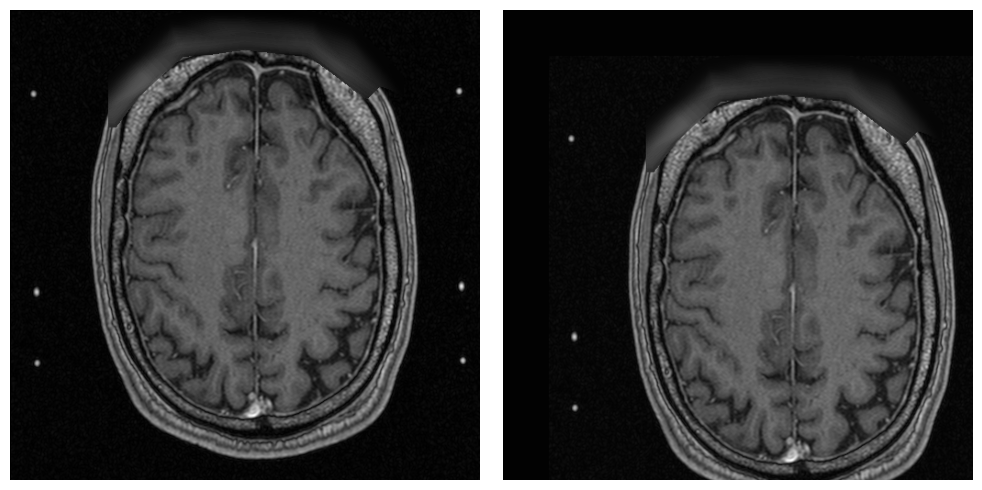

Resampling Result (left: resampled image, right: back-transformed image)


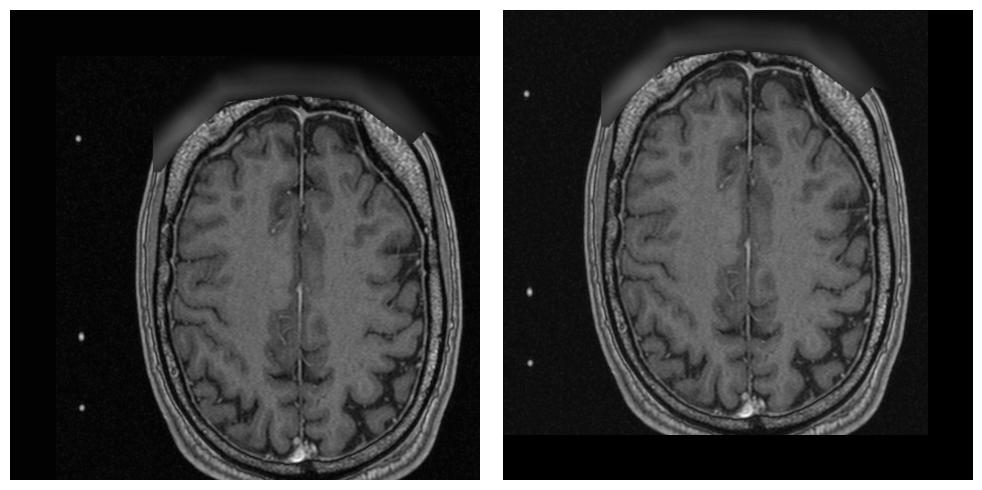

In [ ]:
def resample_and_transform_images(subject_: ps_data.Subject) -> ps_data.Subject:
    # Resamples all images and applies a transformation to the content

    # Create the transform
    transform = sitk.AffineTransform(3)
    transform.SetTranslation((-20, -20, 0))

    # Set the filter parameters
    output_size = None  # aka do not change size
    output_spacing = None  # aka do not change spacing
    centering_method = 'none'  # do not use advanced capabilities
    params = ps_proc.ResampleFilterParams(output_size, output_spacing,
                                          transform=transform,
                                          centering_method=centering_method)

    # Execute the filter
    return ps_proc.ResampleFilter().execute(subject_, params)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = resample_and_transform_images(subject)

# Show the result
print('Resampling Result (left: original image, right: resampled image)')

processed_image = subject.get_image_by_modality('T1').get_image_data(True)
show_images(image_left=previous_image,
            image_right=processed_image)

# Playback transform tape
subject.playback_transform_tapes()
print('Resampling Result (left: resampled image, right: back-transformed image)')

back_transformed_image = subject.get_image_by_modality('T1').get_image_data(True)
show_images(image_left=processed_image,
            image_right=back_transformed_image)

### Resampling to new Spatial Properties

In this example, the `ResampleFilter` is used to change the output size and spacing of the provided subject images.

Resampling Result (left: original image, right: resampled image)


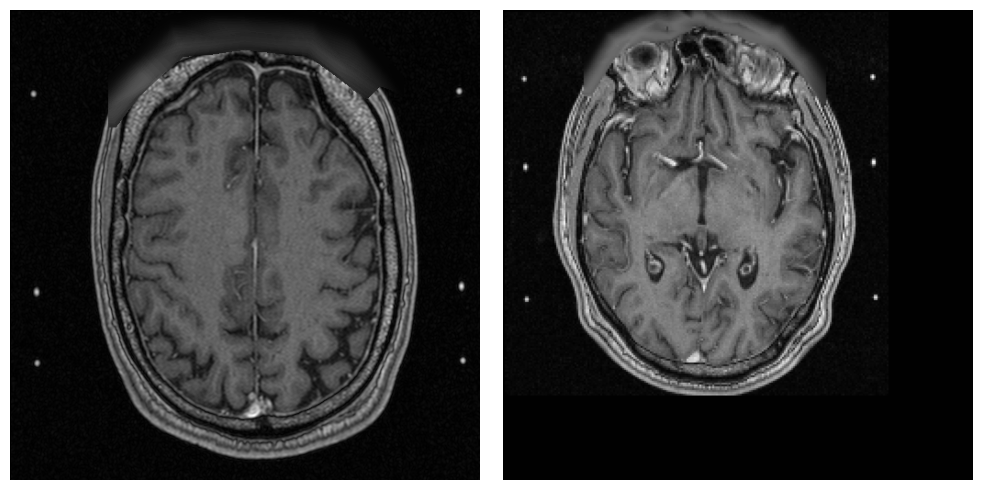

Resampling Result (left: resampled image, right: back-transformed image)


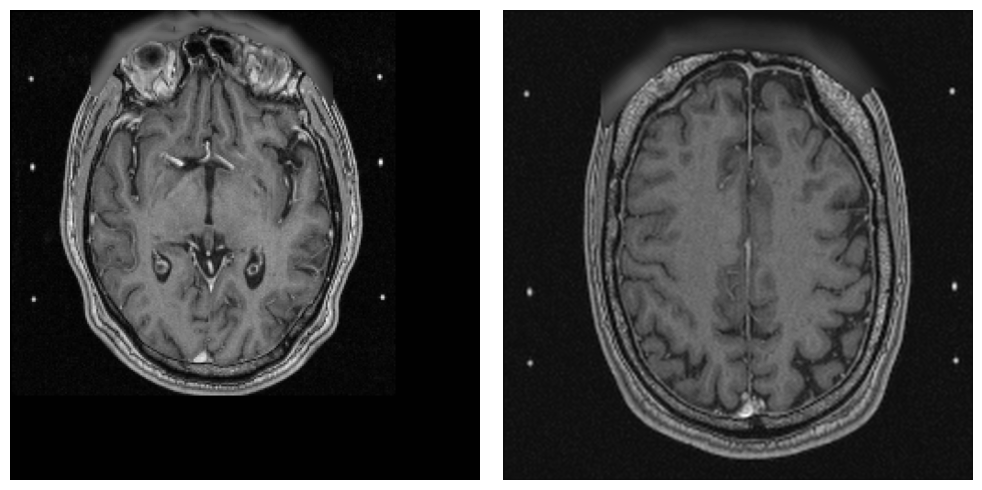

In [ ]:
def resample_with_new_extent_images(subject_: ps_data.Subject) -> ps_data.Subject:
    # Resamples all images with a new image extent

    # Set the filter parameters
    output_size = (256, 256, 300)  # use a new size
    output_spacing = (1, 1, 1)  # change spacing to unit voxel
    centering_method = 'none'  # do not use advanced capabilities
    params = ps_proc.ResampleFilterParams(output_size, output_spacing)

    # Execute the filter
    return ps_proc.ResampleFilter().execute(subject_, params)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = resample_with_new_extent_images(subject)

# Show the result
print('Resampling Result (left: original image, right: resampled image)')

processed_image = subject.get_image_by_modality('T1').get_image_data(True)
show_images(image_left=previous_image,
            image_right=processed_image)

# Playback transform tape
subject.playback_transform_tapes()
print('Resampling Result (left: resampled image, right: back-transformed image)')

back_transformed_image = subject.get_image_by_modality('T1').get_image_data(True)
show_images(image_left=processed_image,
            image_right=back_transformed_image)

### Resample with Label Center and Moment Estimation

The `ResampleFilter` implements a heuristic method for centering labels within an image shown next. This method first computes the center of the provided labels and the image's gravity center. Second, the average of both centers is computed as an estimator of the desired image center. This image center estimator has proven helpful when working with labels that are approximately equally distributed around the anatomical center of the patient (e.g., segmentation of neurological structures).

Resampling Result (left: original image, right: resampled image)


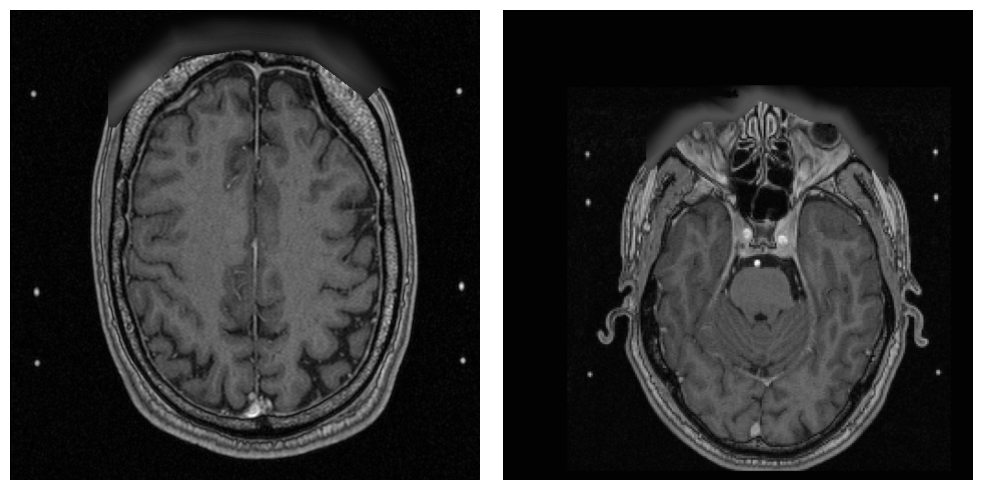

In [ ]:
def resample_with_label_moment_images(subject_: ps_data.Subject) -> ps_data.Subject:
    # Resamples all images and center them according to the label center and image moment

    # Set the filter parameters
    output_size = (256, 256, 160)  # use a new size
    output_spacing = (1, 1, 1)  # change spacing to unit voxel
    centering_method = 'label_moment'  # use label / moment centering
    reference_modality = 'T2'
    params = ps_proc.ResampleFilterParams(output_size, output_spacing,
                                          reference_modality=reference_modality,
                                          centering_method=centering_method)

    # Execute the filter
    return ps_proc.ResampleFilter().execute(subject_, params)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = resample_with_label_moment_images(subject)

# Show the result
print('Resampling Result (left: original image, right: resampled image)')
processed_image = subject.get_image_by_modality('T1').get_image_data(True)

show_images(image_left=previous_image,
            image_right=processed_image)

## Example Series 5: Modification Module

For the [modification module](reference/pyradise.process.modification.rst), the merging of multiple `SegmentationImage`s into a new `SegmentationImage` that gets automatically added to the subject is demonstrated.

Merging Result (left: original TV segmentation, right: merged segmentation)


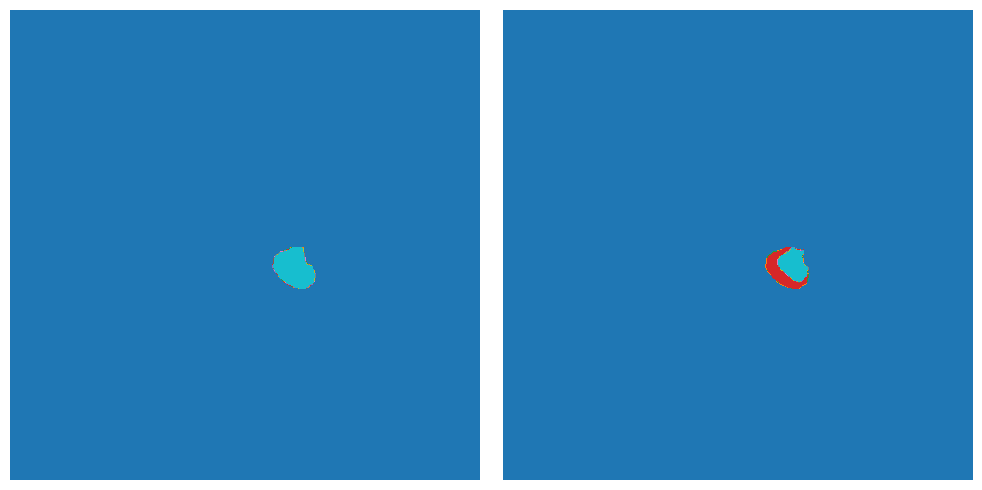

In [ ]:
def merge_segmentations(subject_: ps_data.Subject) -> ps_data.Subject:
    # Merge selected binary segmentation images to one common
    # non-binary segmentation image

    # Set the filter parameters
    organs_to_merge = ('TV', 'Cochlea', 'Vol2016')  # the organs in correct order
    output_organ_indices = (1, 2, 3)  # the indices of the organs in the output
    output_organ = 'Combination'  # the output organ name
    output_rater = 'Jack Example'  # the rater of the output
    params = ps_proc.MergeSegmentationFilterParams(organs_to_merge, output_organ_indices,
                                                   output_organ, output_rater,
                                                   output_orientation='LPS')

    # Execute the filter
    return ps_proc.MergeSegmentationFilter().execute(subject_, params)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing TV segmentation image
previous_image = deepcopy(subject.get_image_by_organ('TV').get_image_data(True))

# Execute the filter on the subject
subject = merge_segmentations(subject)

# Show the result
print('Merging Result (left: original TV segmentation, right: merged segmentation)')
processed_image = subject.get_image_by_organ('Combination').get_image_data(True)

show_images(image_left=previous_image,
            image_right=processed_image,
            slice_index=32, color_map='tab10')

## Example Series 6: Pipeline Construction & Invertibility

This example demonstrates the construction of a `FilterPipeline`. Furthermore, the invertibility feature (see `PlaybackTransformTapeFilter`) is shown.

Playback Result (left: original image, right: modified and played back image)


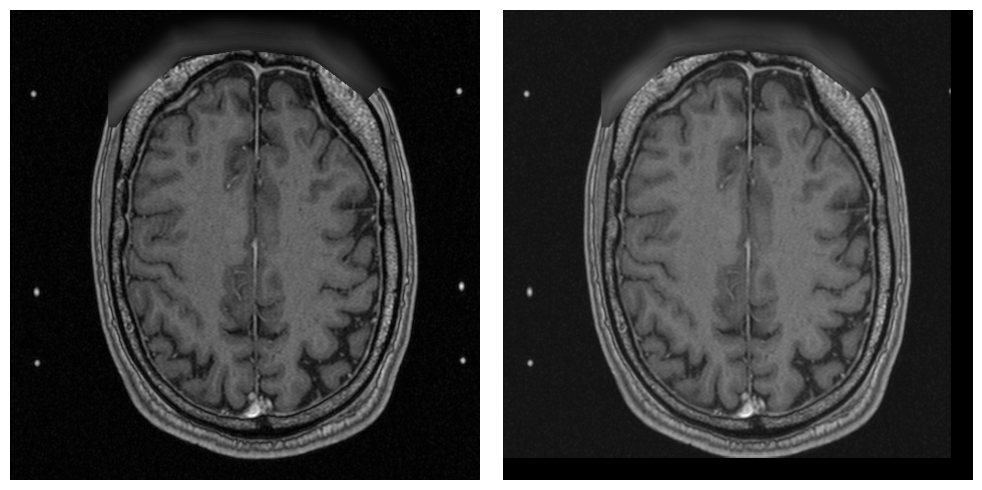

In [8]:
def pipline_based_resampling(subject_: ps_data.Subject) -> ps_data.Subject:
    # Resamples all images and applies a transformation to the content

    # Create a new pipeline
    pipeline = ps_proc.FilterPipeline()

    # Create the first filter
    # ----------------------
    # Create a transform
    transform = sitk.AffineTransform(3)
    transform.SetTranslation((-10, -10, -10))

    # Create the filter parameters
    resample_1_params = ps_proc.ResampleFilterParams(None, None,
                                                   transform=transform)

    # Add the filter to the pipeline
    pipeline.add_filter(ps_proc.ResampleFilter(),
                        resample_1_params)

    # Create the second filter
    # ------------------------
    # Create a transform
    transform = sitk.AffineTransform(3)
    transform.SetTranslation((-20, -20, -20))

    # Create the filter parameters
    output_size = (600, 600, 300)
    output_spacing = (0.5, 0.5, 1)
    resample_2_params = ps_proc.ResampleFilterParams(output_size,
                                                     output_spacing,
                                                     transform=transform)

    # Add the filter to the pipeline
    pipeline.add_filter(ps_proc.ResampleFilter(),
                        resample_2_params)

    # Create the third filter
    # -----------------------
    # Create the filter parameters
    playback_params = ps_proc.PlaybackTransformTapeFilterParams()

    # Add the filter to the pipeline
    pipeline.add_filter(ps_proc.PlaybackTransformTapeFilter(),
                        playback_params)

    # Execute the pipeline
    return pipeline.execute(subject)


# Load the subject from disk
subject = load_subject(input_subject_dir_path_1)

# Make a copy of the existing T1 image
previous_image = deepcopy(subject.get_image_by_modality('T1').get_image_data(True))

# Execute the filter on the subject
subject = pipline_based_resampling(subject)

# Show the result
print('Playback Result (left: original image, right: modified and played back image)')

processed_image = subject.get_image_by_modality('T1').get_image_data(True)
show_images(image_left=previous_image,
            image_right=processed_image)